In [13]:
import torch
torch.manual_seed(1337)

batch_size = 2
sequence_length = 4
d_model = 3
representations = torch.randint(0, 100, (batch_size, sequence_length, d_model)).float()
representations

tensor([[[15., 57., 92.],
         [ 0., 95., 53.],
         [15., 10., 34.],
         [90., 12., 20.]],

        [[97., 86., 90.],
         [38., 51., 64.],
         [ 9., 15., 13.],
         [46., 22., 50.]]])

## generilize a special case
> This is a bit more of a general coding tip but I’ve often seen people create bugs when they bite off more than they can chew, writing a relatively general functionality from scratch. I like to write a very specific function to what I’m doing right now, get that to work, and then generalize it later making sure that I get the same result. Often this applies to vectorizing code, where I almost always write out the fully loopy version first and only then transform it to vectorized code one loop at a time.

https://karpathy.github.io/2019/04/25/recipe/

In [14]:
aggregated_representations = torch.empty((batch_size, sequence_length, d_model))

for batch_idx in range(batch_size):
    for sequence_idx in range(sequence_length):
        aggregated_representations[batch_idx, sequence_idx] = torch.mean(representations[batch_idx, :sequence_idx+1], dim=0)
aggregated_representations

tensor([[[15.0000, 57.0000, 92.0000],
         [ 7.5000, 76.0000, 72.5000],
         [10.0000, 54.0000, 59.6667],
         [30.0000, 43.5000, 49.7500]],

        [[97.0000, 86.0000, 90.0000],
         [67.5000, 68.5000, 77.0000],
         [48.0000, 50.6667, 55.6667],
         [47.5000, 43.5000, 54.2500]]])

In [15]:
attention_score = torch.tril(torch.ones((batch_size, sequence_length, sequence_length)))
attention_score = attention_score / torch.sum(attention_score, dim=2, keepdim=True)
attention_score

tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.5000, 0.5000, 0.0000, 0.0000],
         [0.3333, 0.3333, 0.3333, 0.0000],
         [0.2500, 0.2500, 0.2500, 0.2500]],

        [[1.0000, 0.0000, 0.0000, 0.0000],
         [0.5000, 0.5000, 0.0000, 0.0000],
         [0.3333, 0.3333, 0.3333, 0.0000],
         [0.2500, 0.2500, 0.2500, 0.2500]]])

In [16]:
attention_score @ representations

tensor([[[15.0000, 57.0000, 92.0000],
         [ 7.5000, 76.0000, 72.5000],
         [10.0000, 54.0000, 59.6667],
         [30.0000, 43.5000, 49.7500]],

        [[97.0000, 86.0000, 90.0000],
         [67.5000, 68.5000, 77.0000],
         [48.0000, 50.6667, 55.6667],
         [47.5000, 43.5000, 54.2500]]])

In [17]:
tril = torch.tril(torch.ones((sequence_length, sequence_length)))
qk_dot_product = torch.randn((batch_size, sequence_length, sequence_length))
qk_dot_product = qk_dot_product.masked_fill(tril == 0, float('-inf'))
qk_dot_product

tensor([[[-0.0476,    -inf,    -inf,    -inf],
         [-1.1081, -1.8002,    -inf,    -inf],
         [ 0.1662,  1.2055,  0.1883,    -inf],
         [-0.1585, -0.6300, -0.2221,  0.6924]],

        [[ 1.1490,    -inf,    -inf,    -inf],
         [ 0.1526,  0.3843,    -inf,    -inf],
         [-0.7296, -1.5580, -0.3950,    -inf],
         [-1.7097, -0.0826, -0.0495, -1.4480]]])

In [18]:
torch.softmax(qk_dot_product, dim=2)

tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.6664, 0.3336, 0.0000, 0.0000],
         [0.2062, 0.5830, 0.2108, 0.0000],
         [0.2039, 0.1273, 0.1913, 0.4775]],

        [[1.0000, 0.0000, 0.0000, 0.0000],
         [0.4424, 0.5576, 0.0000, 0.0000],
         [0.3528, 0.1541, 0.4931, 0.0000],
         [0.0791, 0.4024, 0.4159, 0.1027]]])

In [19]:
d_head = 16
k = torch.randn(batch_size, sequence_length, d_head)
q = torch.randn(batch_size, sequence_length, d_head)
v = torch.randn(batch_size, sequence_length, d_head)

qk_dot_product = q @ k.transpose(-2, -1)
scaled_qk_dot_product = qk_dot_product / (d_head ** 0.5)

In [20]:
k.var()

tensor(0.8750)

In [21]:
q.var()

tensor(1.1169)

In [22]:
qk_dot_product.var(), scaled_qk_dot_product.var()

(tensor(13.3547), tensor(0.8347))

In [23]:
torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5]), dim=-1)

tensor([0.1925, 0.1426, 0.2351, 0.1426, 0.2872])

In [24]:
torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5])* 8, dim=-1)

tensor([0.0326, 0.0030, 0.1615, 0.0030, 0.8000])

In [35]:
import torch
import torch.nn as nn
from torch.nn import functional as F

torch.manual_seed(1337)

class Head(nn.Module):
    def __init__(self, d_model, d_head):
        super().__init__()
        self.key = nn.Linear(d_model, d_head, bias=False)
        self.query = nn.Linear(d_model, d_head, bias=False)
        self.value = nn.Linear(d_model, d_head, bias=False)
        self.back_to_d_model = nn.Linear(d_head, d_model)

        self.register_buffer('mask', torch.tril(torch.ones((sequence_length, sequence_length))))
        
    
    def forward(self, x):
        # x: (batch_size, sequence_length, d_model)
        k = self.key(x)
        q = self.query(x)
        v = self.value(x)

        qk_dot_product = q @ k.transpose(-2, -1) / (d_head ** 0.5)
        qk_dot_product = qk_dot_product.masked_fill(self.mask == 0, float('-inf'))
        attention_score = torch.softmax(qk_dot_product, dim=-1)
        out = attention_score @ v
        out = self.back_to_d_model(out)
        return out


class AttentionLM(nn.Module):
    def __init__(self, vocab_size, sequence_length, d_model, d_head):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, d_model)
        self.pos_embed = nn.Embedding(sequence_length, d_model)
        self.head = Head(d_model, d_head)
        self.ln = nn.LayerNorm(d_model)
        self.unembed = nn.Linear(d_model, vocab_size)
        print('number of parameters:', sum(p.numel() for p in self.parameters()))
    
    
    def forward(self, token_indexes):
        # token_indexes: (batch_size, sequence_length)
        batch_size, sequence_length = token_indexes.size()
        token_embed = self.embed(token_indexes)
        pos_embed = self.pos_embed(torch.arange(sequence_length).to(token_embed.device))
        x = token_embed + pos_embed
        x = self.head(x)
        x = self.ln(x)
        logits = self.unembed(x)

        return logits
    
    def loss_per_token(self, token_indexes, targets):
        logits = self(token_indexes)
        # logits: (batch_size, sequence_length, vocab_size)
        # targets: (batch_size, sequence_length)
        batch_size, sequence_length, vocab_size = logits.shape
        loss = F.cross_entropy(
            logits.view(batch_size*sequence_length, vocab_size),
            targets.view(batch_size*sequence_length),
            reduction='none'
            )
        # loss: (batch_size*sequence_length)
        return loss.view(batch_size, sequence_length)
    
    def loss(self, token_indexes, targets):
        logits = self(token_indexes)
        # logits: (batch_size, sequence_length, vocab_size)
        # targets: (batch_size, sequence_length)
        batch_size, sequence_length, vocab_size = logits.shape
        loss = F.cross_entropy(
            logits.view(batch_size*sequence_length, vocab_size),
            targets.view(batch_size*sequence_length)
            )
        # loss: scalar
        return loss
    
    def generate(self, token_indexes, max_new_tokens):
        # token_indexes: (batch_size, sequence_length)
        batch_size, sequence_length = token_indexes.shape
        for _ in range(max_new_tokens):
            logits = self(token_indexes)
            # logits: (batch_size, sequence_length, vocab_size)
            next_token_logits = logits[:, -1, :]
            # next_token_logits: (batch_size, vocab_size)
            next_token_probs = F.softmax(next_token_logits, dim=-1)
            # next_token_probs: (batch_size, vocab_size)
            next_token = torch.multinomial(next_token_probs, num_samples=1)
            # next_token: (batch_size, 1)
            token_indexes = torch.cat([token_indexes, next_token], dim=1)
            # token_indexes: (batch_size, sequence_length+1)
        return token_indexes


class BigramLanguageModel(nn.Module):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        # self.bigram_table = nn.Embedding(vocab_size, vocab_size)
        self.token_embedding_table = nn.Embedding(vocab_size, d_model)
        self.ln = nn.LayerNorm(d_model)
        self.linear = nn.Linear(d_model, vocab_size)
        print('number of parameters:', sum(p.numel() for p in self.parameters()))
    
    def forward(self, token_indexes):
        # token_index: (batch_size, sequence_length)
        # logits = self.bigram_table(token_indexes)

        embedding = self.token_embedding_table(token_indexes)
        embedding = self.ln(embedding)
        logits = self.linear(embedding)
        # logits: (batch_size, sequence_length, vocab_size)
        return logits

    def loss_per_token(self, token_indexes, targets):
        logits = self(token_indexes)
        # logits: (batch_size, sequence_length, vocab_size)
        # targets: (batch_size, sequence_length)
        batch_size, sequence_length, vocab_size = logits.shape
        loss = F.cross_entropy(
            logits.view(batch_size*sequence_length, vocab_size),
            targets.view(batch_size*sequence_length),
            reduction='none'
            )
        # loss: (batch_size*sequence_length)
        return loss.view(batch_size, sequence_length)
    
    
    def loss(self, token_indexes, targets):
        logits = self(token_indexes)
        # logits: (batch_size, sequence_length, vocab_size)
        # targets: (batch_size, sequence_length)
        batch_size, sequence_length, vocab_size = logits.shape
        loss = F.cross_entropy(
            logits.view(batch_size*sequence_length, vocab_size),
            targets.view(batch_size*sequence_length)
            )
        # loss: scalar
        return loss
    
    def generate(self, token_indexes, max_new_tokens):
        # token_indexes: (batch_size, sequence_length)
        batch_size, sequence_length = token_indexes.shape
        for _ in range(max_new_tokens):
            logits = self(token_indexes)
            # logits: (batch_size, sequence_length, vocab_size)
            next_token_logits = logits[:, -1, :]
            # next_token_logits: (batch_size, vocab_size)
            next_token_probs = F.softmax(next_token_logits, dim=-1)
            # next_token_probs: (batch_size, vocab_size)
            next_token = torch.multinomial(next_token_probs, num_samples=1)
            # next_token: (batch_size, 1)
            token_indexes = torch.cat([token_indexes, next_token], dim=1)
            # token_indexes: (batch_size, sequence_length+1)
        return token_indexes


In [36]:
from data_char import enc, get_batch
vocab_size = enc.n_vocab
sequence_length = 1024
d_model = 768
d_head = 64

model = AttentionLM(vocab_size, sequence_length, d_model, d_head).cuda()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
batch_size = 32
context_length = 1024
iterations = 300
x, y = get_batch(batch_size, context_length, 'train')
for steps in range(iterations):
    # print(x[0], y[0])
    x, y = x.cuda(), y.cuda()
    loss = model.loss(x, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if steps % 100 == 0:
        print('steps:', steps, 'loss:', loss.item())
    # break
print('steps:', steps, 'loss:', loss.item())

with torch.no_grad():
    val_x, val_y = get_batch(1, context_length, 'val')
    val_x, val_y = val_x.cuda(), val_y.cuda()
    loss = model.loss(val_x, val_y)
    print('validation loss:', loss.item())

number of parameters: 1085249
steps: 0 loss: 4.328359603881836
steps: 100 loss: 1.9020140171051025
steps: 200 loss: 0.9388523697853088
steps: 299 loss: 0.45989322662353516
validation loss: 8.844975471496582


Text(0.5, 1.0, 'loss per token')

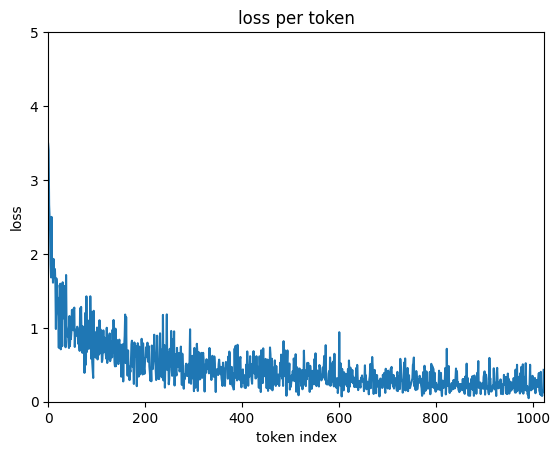

In [37]:
from matplotlib import pyplot as plt
loss_per_token = model.loss_per_token(x,y)
loss = model.loss(x,y)
loss_per_token.mean().item(), loss.item()
# print(loss_per_token.shape)

# plot by points
plt.plot(loss_per_token.mean(dim=0).detach().cpu().numpy())
# x-axis 0 ~ 1024
plt.xlim(0, 1024)
plt.ylim(0, 5)
plt.xlabel('token index')
plt.ylabel('loss')
plt.title('loss per token')

In [38]:
model = BigramLanguageModel(vocab_size, d_model).cuda()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
batch_size = 32
context_length = 1024
iterations = 300
x, y = get_batch(batch_size, context_length, 'train')

for steps in range(iterations):
    # print(x[0], y[0])
    x, y = x.cuda(), y.cuda()
    loss = model.loss(x, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if steps % 100 == 0:
        print('steps:', steps, 'loss:', loss.item())
print('steps:', steps, 'loss:', loss.item())
with torch.no_grad():
    val_x, val_y = get_batch(1, context_length, 'val')
    val_x, val_y = val_x.cuda(), val_y.cuda()
    loss = model.loss(val_x, val_y)
    print('validation loss:', loss.item())

number of parameters: 101441
steps: 0 loss: 4.318515300750732
steps: 100 loss: 2.431689500808716
steps: 200 loss: 2.423933744430542
steps: 299 loss: 2.4220685958862305
validation loss: 2.4799563884735107


Text(0.5, 1.0, 'loss per token')

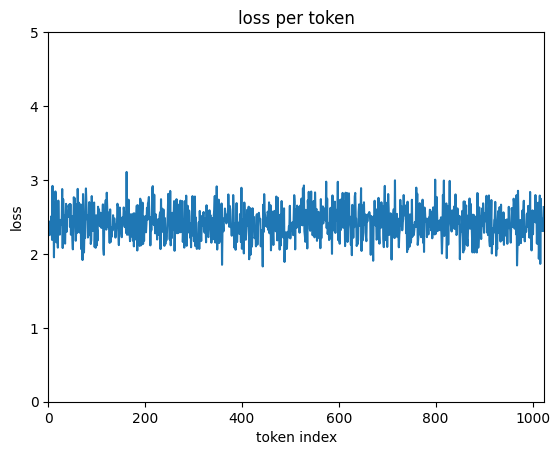

In [39]:
from matplotlib import pyplot as plt
loss_per_token = model.loss_per_token(x,y)
loss = model.loss(x,y)
loss_per_token.mean().item(), loss.item()
# print(loss_per_token.shape)

plt.plot(loss_per_token.mean(dim=0).detach().cpu().numpy())
plt.xlim(0, 1024)
plt.ylim(0, 5)
plt.xlabel('token index')
plt.ylabel('loss')
plt.title('loss per token')

In [30]:
import math
-math.log(1/vocab_size)

4.174387269895637

In [31]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, d_model, d_head):
        super().__init__()
        self.key = nn.Linear(d_model, d_head, bias=False)
        self.query = nn.Linear(d_model, d_head, bias=False)
        self.value = nn.Linear(d_model, d_head, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(sequence_length, sequence_length)))

        # self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        # wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, d_model, d_head):
        super().__init__()
        self.heads = nn.ModuleList([Head(d_model, d_head) for _ in range(num_heads)])
        self.proj = nn.Linear(d_model, d_model)
        # self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        # out = self.dropout(self.proj(out))
        out = self.proj(out)
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, d_model):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_model, 4 * d_model),
            nn.ReLU(),
            nn.Linear(4 * d_model, d_model),
            # nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, d_model, d_head, num_heads):
        # d_model: embedding dimension, num_heads: the number of heads we'd like
        super().__init__()
        d_head = d_model // num_heads
        self.sa = MultiHeadAttention(num_heads, d_model, d_head)
        self.ffwd = FeedFoward(d_model)
        self.ln1 = nn.LayerNorm(d_model)
        self.ln2 = nn.LayerNorm(d_model)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

# super simple bigram model
class AttentionLM(nn.Module):

    def __init__(self, vocab_size, sequence_length, d_model, d_head, num_heads, n_layer):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, d_model)
        self.position_embedding_table = nn.Embedding(sequence_length, d_model)
        self.blocks = nn.Sequential(*[Block(d_model, d_head=d_head, num_heads=num_heads) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(d_model) # final layer norm
        self.lm_head = nn.Linear(d_model, vocab_size)
        print('number of parameters:', sum(p.numel() for p in self.parameters()))
    
    def forward(self, idx):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=tok_emb.device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)
        return logits

    def loss(self, token_indexes, targets):
        logits = self(token_indexes)
        # logits: (batch_size, sequence_length, vocab_size)
        # targets: (batch_size, sequence_length)
        batch_size, sequence_length, vocab_size = logits.shape
        loss = F.cross_entropy(
            logits.view(batch_size*sequence_length, vocab_size),
            targets.view(batch_size*sequence_length)
            )
        # loss: scalar
        return loss
    
    def generate(self, token_indexes, max_new_tokens):
        # token_indexes: (batch_size, sequence_length)
        batch_size, sequence_length = token_indexes.shape
        for _ in range(max_new_tokens):
            logits = self(token_indexes)
            # logits: (batch_size, sequence_length, vocab_size)
            next_token_logits = logits[:, -1, :]
            # next_token_logits: (batch_size, vocab_size)
            next_token_probs = F.softmax(next_token_logits, dim=-1)
            # next_token_probs: (batch_size, vocab_size)
            next_token = torch.multinomial(next_token_probs, num_samples=1)
            # next_token: (batch_size, 1)
            token_indexes = torch.cat([token_indexes, next_token], dim=1)
            # token_indexes: (batch_size, sequence_length+1)
        return token_indexes
    
    def loss_per_token(self, token_indexes, targets):
        logits = self(token_indexes)
        # logits: (batch_size, sequence_length, vocab_size)
        # targets: (batch_size, sequence_length)
        batch_size, sequence_length, vocab_size = logits.shape
        loss = F.cross_entropy(
            logits.view(batch_size*sequence_length, vocab_size),
            targets.view(batch_size*sequence_length),
            reduction='none'
            )
        # loss: (batch_size*sequence_length)
        return loss.view(batch_size, sequence_length)

## Overfit one batch
>  Overfit a single batch of only a few examples (e.g. as little as two). To do so we increase the capacity of our model (e.g. add layers or filters) and verify that we can reach the lowest achievable loss (e.g. zero). I also like to visualize in the same plot both the label and the prediction and ensure that they end up aligning perfectly once we reach the minimum loss. If they do not, there is a bug somewhere and we cannot continue to the next stage.

> The approach I like to take to finding a good model has two stages: first get a model large enough that it can overfit (i.e. focus on training loss) and then regularize it appropriately (give up some training loss to improve the validation loss). The reason I like these two stages is that if we are not able to reach a low error rate with any model at all that may again indicate some issues, bugs, or misconfiguration.

https://karpathy.github.io/2019/04/25/recipe/

In [32]:
from data_char import enc, get_batch
vocab_size = enc.n_vocab
sequence_length = 1024
d_model = 768
d_head = 64
n_layer = 2
num_heads = 12

model = AttentionLM(vocab_size, sequence_length, d_model, d_head, num_heads, n_layer).cuda()
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4)
batch_size = 32
context_length = 1024
iterations = 1000
x, y = get_batch(batch_size, context_length, 'train')
for steps in range(iterations):
    # print(x[0], y[0])
    x, y = x.cuda(), y.cuda()
    loss = model.loss(x, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if steps % 100 == 0:
        print('steps:', steps, 'loss:', loss.item())
print('steps:', steps, 'loss:', loss.item())

with torch.no_grad():
    val_x, val_y = get_batch(1, context_length, 'val')
    val_x, val_y = val_x.cuda(), val_y.cuda()
    loss = model.loss(val_x, val_y)
    print('validation loss:', loss.item())

number of parameters: 15059009
steps: 0 loss: 4.373307228088379
steps: 100 loss: 1.3534984588623047
steps: 200 loss: 0.14664000272750854
steps: 300 loss: 0.007650444284081459
steps: 400 loss: 0.003188813803717494
steps: 500 loss: 0.0019986487459391356
steps: 600 loss: 0.0014852412277832627
steps: 700 loss: 0.0012111642863601446
steps: 800 loss: 0.0010455630254000425
steps: 900 loss: 0.0009370149346068501
steps: 999 loss: 0.0008622257155366242
validation loss: 11.710304260253906


In [33]:
math.exp(4.998233271180652e-05)

1.0000499835818495

Text(0.5, 1.0, 'loss per token')

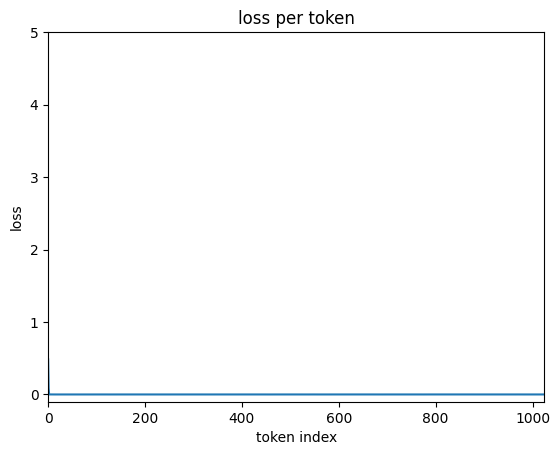

In [34]:
from matplotlib import pyplot as plt
loss_per_token = model.loss_per_token(x,y)
loss = model.loss(x,y)
loss_per_token.mean().item(), loss.item()
# print(loss_per_token.shape)

plt.plot(loss_per_token.mean(dim=0).detach().cpu().numpy())
plt.xlim(0, 1024)
plt.ylim(-0.1, 5)
plt.xlabel('token index')
plt.ylabel('loss')
plt.title('loss per token')

## References
- https://www.youtube.com/watch?v=kCc8FmEb1nY  
- https://github.com/karpathy/ng-video-lecture  
- https://colab.research.google.com/drive/1JMLa53HDuA-i7ZBmqV7ZnA3c_fvtXnx-?usp=sharing  